# plot intensity variance vs time for 5D images
This notebook is designed for looking at a single batch of data and do various diagnostic plots to decide how to filter the data.


In [2]:
import napari
import torch
from skimage.measure import regionprops_table, regionprops
import scipy as sp
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob
import os
from matplotlib_scalebar.scalebar import ScaleBar
import gc
import seaborn as sns
from sklearn.mixture import GaussianMixture
from bioio import BioImage
import bioio_nd2
import bioio_tifffile
from bioio.writers import OmeTiffWriter


anisotropy = (3.2,1,1) # Relative scale of (Z,X,Y) axes

nucChannel = 0 # red emerin rings
spotChannel = 1 # green spots

# in lucien's original scripts:
# channel 0 is green spots
# channel 1 is red emerin

In [3]:
# on server
base_path = '/mnt/external.data/MeisterLab/jsemple/lhinder/segmentation_Dario/'
df_paths = pd.DataFrame.from_dict({'data_path': [base_path+'/DPY27/1268/20241107_hs/']})

output_path=base_path+'/DPY27_hs/'

if not os.path.exists(output_path+"/plots"):
    os.makedirs(output_path+"/plots")

df=pd.DataFrame()
dist=pd.DataFrame()
for path in df_paths['data_path']:
    df_tmp=pd.read_csv(path+"nuclei_analysis_v001.csv")
    df = pd.concat([df,df_tmp])
    dist_tmp=pd.read_pickle(path+"dist_analysis_v001.pkl")
    dist = pd.concat([dist,dist_tmp])

df.head()
dist.head()

,label,bb_dimZ,bb_dimY,bb_dimX,centroid_z,centroid_y,centroid_x,major_axis_length,solidity,mean,...,max,min,volume,id,timepoint,intensity_dist_nuclei,intensity_dist_spots,intensity_dist,zproj_spots,zproj_nuclei
0,1,9,54,47,4.027346,314.717249,368.225029,58.120135,0.891337,115.966727,...,246,87,14847,DPY27_hs_20241107_1268_E_30minHS_3h_5min_5um,0,"[107.35106382978724, 108.04918032786885, 107.0...","[106.27659574468085, 105.89071038251366, 107.1...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
0,2,3,59,54,0.927409,336.729282,430.982658,65.120716,0.945033,113.941835,...,214,86,6516,DPY27_hs_20241107_1268_E_30minHS_3h_5min_5um,0,"[105.765, 106.71573604060913, 106.051851851851...","[107.98, 108.13197969543147, 107.2444444444444...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
0,3,7,51,55,2.672024,355.632537,499.332055,58.319842,0.926455,112.046504,...,203,87,12257,DPY27_hs_20241107_1268_E_30minHS_3h_5min_5um,0,"[108.26136363636364, 108.59770114942529, 109.0...","[106.57954545454545, 106.40229885057471, 105.9...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 97, 1...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 110, ..."
0,4,8,66,51,3.103585,392.035978,375.988028,69.539366,0.863446,113.476782,...,193,85,15871,DPY27_hs_20241107_1268_E_30minHS_3h_5min_5um,0,"[107.00947867298578, 106.92924528301887, 107.0...","[109.23222748815166, 110.34905660377359, 110.7...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
0,5,3,44,45,0.925410,440.956987,614.346096,47.341280,0.941479,113.823720,...,189,90,4022,DPY27_hs_20241107_1268_E_30minHS_3h_5min_5um,0,"[109.53164556962025, 110.11842105263158, 110.4...","[110.99367088607595, 113.11842105263158, 114.0...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."


## Add some variables
Radius might scale more linearly than volume
Coefficient of variation is independent of the mean signal

In [39]:
def radiusFromVolume(volume):
    return (3*volume/(4*np.pi))**(1/3)

def coefficientOfVariation(std,mean):
    return std/mean

timeInterval=5

df['cv'] = coefficientOfVariation(df['std'],df['mean'])
df['time'] = df['timepoint']*timeInterval

df.head()


,label,bb_dimZ,bb_dimY,bb_dimX,centroid_z,centroid_y,centroid_x,major_axis_length,solidity,mean,...,strain,protein,raw_filepath,denoised_filepath,radius,cv,zx_ratio,zy_ratio,xy_ratio,time
0,1,9,54,47,4.027346,314.717249,368.225029,58.120135,0.891337,115.966727,...,1268,DPY27,/mnt/external.data/MeisterLab/Dario/Imaging/DP...,/mnt/external.data/MeisterLab/Dario/Imaging/DP...,15.246964,0.186374,0.612766,0.533333,0.870370,0
1,2,3,59,54,0.927409,336.729282,430.982658,65.120716,0.945033,113.941835,...,1268,DPY27,/mnt/external.data/MeisterLab/Dario/Imaging/DP...,/mnt/external.data/MeisterLab/Dario/Imaging/DP...,11.586817,0.146945,0.177778,0.162712,0.915254,0
2,3,7,51,55,2.672024,355.632537,499.332055,58.319842,0.926455,112.046504,...,1268,DPY27,/mnt/external.data/MeisterLab/Dario/Imaging/DP...,/mnt/external.data/MeisterLab/Dario/Imaging/DP...,14.303155,0.122921,0.407273,0.439216,1.078431,0
3,4,8,66,51,3.103585,392.035978,375.988028,69.539366,0.863446,113.476782,...,1268,DPY27,/mnt/external.data/MeisterLab/Dario/Imaging/DP...,/mnt/external.data/MeisterLab/Dario/Imaging/DP...,15.589729,0.133807,0.501961,0.387879,0.772727,0
4,5,3,44,45,0.925410,440.956987,614.346096,47.341280,0.941479,113.823720,...,1268,DPY27,/mnt/external.data/MeisterLab/Dario/Imaging/DP...,/mnt/external.data/MeisterLab/Dario/Imaging/DP...,9.865471,0.102801,0.213333,0.218182,1.022727,0


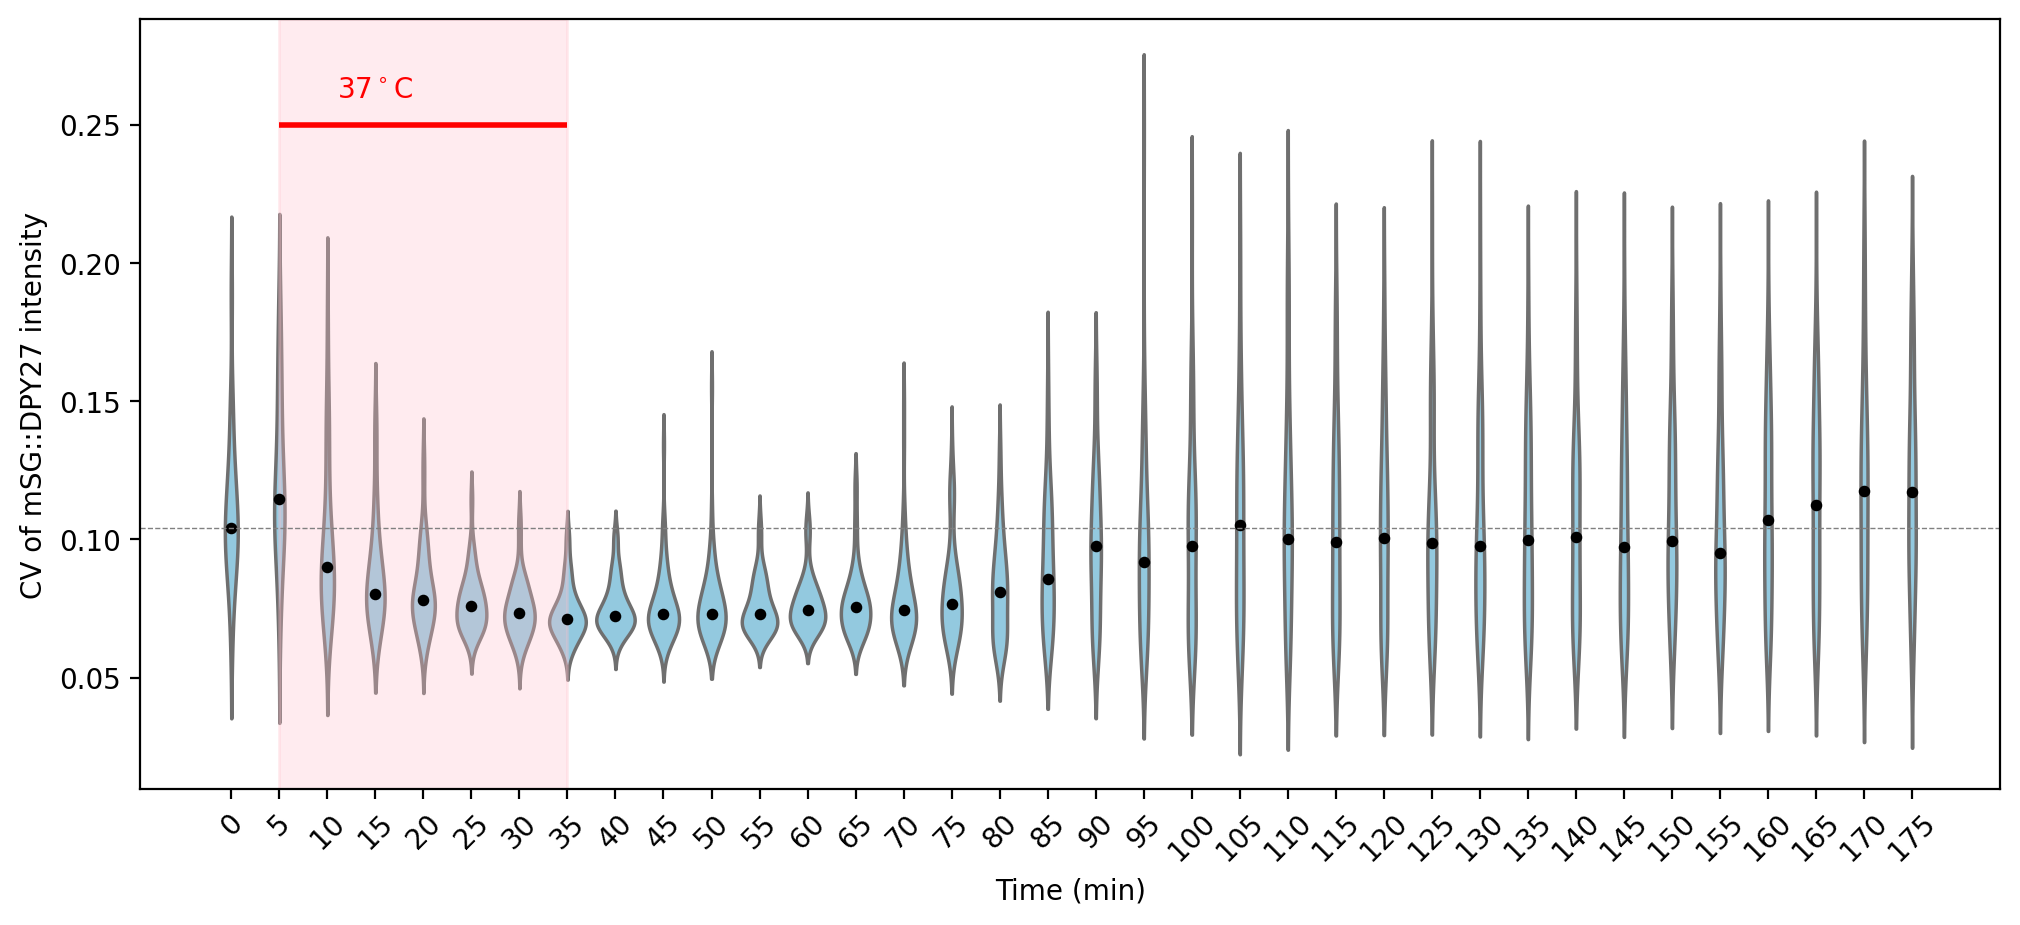

In [83]:
plt.figure(figsize = (12,5),dpi = 200)
#plt.ylim((0,100))
sns.violinplot(data=df, y="cv", x="time",color="skyblue", inner=None)
#plt.title(df.protein.iloc[0]+'::mSG signal upon heatshock') 
plt.xticks(rotation=45)
plt.xlabel("Time (min)")
plt.ylabel("CV of mSG::"+df.protein.iloc[0]+" intensity")
plt.hlines(y=0.25, xmin=1, xmax=7, color='red', linewidth=2)
plt.text(x=3, y=0.26, s='37$^\circ$C', color='red', ha='center')

plt.axvspan(1, 7, color='pink', alpha=0.3)

t0_mean = df[df['time'] == 0]['cv'].median()
plt.axhline(y=t0_mean, color='grey', linestyle='--', linewidth=0.5)
medians_df = df.groupby(['timepoint','time'])['cv'].median().reset_index(name='Median')
plt.scatter(x=medians_df.timepoint, y=medians_df.Median, color='black', s=10)
